# Heavy Users Over Time - No Search Counts

####Heavy User Definition

The analysis of Heavy Users can be seen in this notebook: <a href="https://dbc-caf9527b-e073.cloud.databricks.com/#notebook/70791/command/70792">Heavy User Cutoffs</a>

Look at Heavy Users over a week and Heavy User Retention.

In [5]:
import pyspark.sql.functions as F
import pyspark.sql.types as st
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from datetime import datetime

###Prepare Data

In [7]:
#Global variables
sample_id = 42
hu_start_date = '20180926'  # Calculations will look back 6 days before this for week average
number_days = 7
num_weeks = 6

In [8]:
sum_query = """
    SELECT 
      client_id,
      submission_date_s3,
      sum(coalesce(scalar_parent_browser_engagement_total_uri_count, 0)) AS td_uri, 
      sum(coalesce(scalar_parent_browser_engagement_active_ticks, 0)*5/3600) AS td_active_hours,
      first(sample_id) AS sample_id
    FROM main_summary
    WHERE 
      app_name='Firefox'
      AND submission_date_s3 >= '{}'
      AND submission_date_s3 <= '{}'
      AND sample_id = '{}'
    GROUP BY
        1, 2
    """

search_query = """
  SELECT client_id,
         submission_date_s3,
         engine,
         SUM(sap) as sap,
         SUM(tagged_sap) as tagged_sap,
         SUM(tagged_follow_on) as tagged_follow_on,
         SUM(organic) as in_content_organic
  FROM search_clients_daily
  WHERE
      submission_date_s3 >= '{}'
      AND submission_date_s3 <= '{}'
      AND sample_id = '{}'
  GROUP BY
      1, 2, 3
    """

#### Get multiple weeks of cutoffs

In [10]:
# Get a week start and end date for number_days consecutive days
wk_st_end = []
num_wk_days = num_weeks * 7
for x in range(0, num_wk_days+1):
    wk_st_end.append([(pd.to_datetime(hu_start_date) + pd.DateOffset(days=x-6)).strftime('%Y%m%d'), 
                      (pd.to_datetime(hu_start_date) + pd.DateOffset(days=x)).strftime('%Y%m%d')])

In [11]:
wk_st_end

Out[ 5 ]: 
[['20180920', '20180926'],
 ['20180921', '20180927'],
 ['20180922', '20180928'],
 ['20180923', '20180929'],
 ['20180924', '20180930'],
 ['20180925', '20181001'],
 ['20180926', '20181002'],
 ['20180927', '20181003'],
 ['20180928', '20181004'],
 ['20180929', '20181005'],
 ['20180930', '20181006'],
 ['20181001', '20181007'],
 ['20181002', '20181008'],
 ['20181003', '20181009'],
 ['20181004', '20181010'],
 ['20181005', '20181011'],
 ['20181006', '20181012'],
 ['20181007', '20181013'],
 ['20181008', '20181014'],
 ['20181009', '20181015'],
 ['20181010', '20181016'],
 ['20181011', '20181017'],
 ['20181012', '20181018'],
 ['20181013', '20181019'],
 ['20181014', '20181020'],
 ['20181015', '20181021'],
 ['20181016', '20181022'],
 ['20181017', '20181023'],
 ['20181018', '20181024'],
 ['20181019', '20181025'],
 ['20181020', '20181026'],
 ['20181021', '20181027'],
 ['20181022', '20181028'],
 ['20181023', '20181029'],
 ['20181024', '20181030'],
 ['20181025', '20181031'],
 ['20181026', '20181101'],
 ['20181027', '20181102'],
 ['20181028', '20181103'],
 ['20181029', '20181104'],
 ['20181030', '20181105'],
 ['20181031', '20181106'],
 ['20181101', '20181107']]

In [12]:
# This takes a long time
# for the date ranges defined above
ms_wk = []
perc80 = [.8]
error = 0
uri_cutoff = []
sc_cutoff = []
ah_cutoff = []
for i in range(0, len(wk_st_end)):
    # Get the week's data for an endday
    ms_sum_wk = spark.sql(sum_query.format(wk_st_end[i][0],wk_st_end[i][1],sample_id))
    search_wk = spark.sql(search_query.format(wk_st_end[i][0],wk_st_end[i][1],sample_id))    
    search_wk = search_wk.na.fill(0)
    search_sum_wk = search_wk.groupBy('client_id', 'submission_date_s3') \
                         .agg(F.sum(F.col('sap') + F.col('in_content_organic'))) \
                         .withColumnRenamed('sum((sap + in_content_organic))','td_search_counts') \
                         .sort('client_id', 'submission_date_s3')
    # Join the main summary and search data for the week
    ms_week = ms_sum_wk.join(search_sum_wk, ['client_id', 'submission_date_s3'], 'full_outer').na.fill(0)

    # Add the week's data to the list of weeks
    ms_wk.append(ms_week)
    # Get the aDAU values for the week
    ms_wk_aDAU = ms_week.where('td_uri >= 5')
    # Average the aDAU values for the week
    ms_wk_avg_aDAU = ms_wk_aDAU.groupBy('client_id').avg() \
        .withColumnRenamed('avg(td_uri)','avg_uri') \
        .withColumnRenamed('avg(td_active_ticks)','avg_active_ticks') \
        .withColumnRenamed('avg(td_active_hours)','avg_active_hours') \
        .withColumnRenamed('avg(td_search_counts)', 'avg_search_counts')
    
    # Get the 80th percentile cutoff for the heavy user type for day and add it to the list of cutoffs
    uri_cutoff.append(ms_wk_avg_aDAU.stat.approxQuantile('avg_uri', perc80, error)[0])
    sc_cutoff.append(ms_wk_avg_aDAU.stat.approxQuantile('avg_search_counts', perc80, error)[0])
    ah_cutoff.append(ms_wk_avg_aDAU.stat.approxQuantile('avg_active_hours', perc80, error)[0])


In [13]:
uri_cutoff

Out[ 7 ]: 
[169.0,
 168.71428571428572,
 168.0,
 168.5,
 167.85714285714286,
 168.0,
 169.0,
 170.0,
 170.5,
 170.57142857142858,
 171.0,
 171.0,
 170.85714285714286,
 170.33333333333334,
 169.0,
 168.25,
 168.71428571428572,
 168.66666666666666,
 168.57142857142858,
 168.5,
 168.5,
 168.8,
 169.4,
 169.14285714285714,
 169.25,
 169.2,
 169.66666666666666,
 170.33333333333334,
 171.0,
 171.5,
 171.8,
 172.0,
 172.6,
 173.0,
 173.0,
 173.28571428571428,
 174.0,
 174.57142857142858,
 175.0,
 174.85714285714286,
 174.0,
 173.8,
 173.42857142857142]

In [14]:
sc_cutoff

Out[ 8 ]: 
[5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.857142857142857,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0]

In [15]:
ah_cutoff

Out[ 9 ]: 
[0.9347222222222223,
 0.9337962962962963,
 0.9319444444444445,
 0.9342592592592593,
 0.9305555555555555,
 0.9316666666666669,
 0.9354166666666666,
 0.9430555555555555,
 0.9442460317460316,
 0.94375,
 0.9447916666666668,
 0.9452777777777779,
 0.9468253968253967,
 0.9444444444444444,
 0.9381944444444444,
 0.9333333333333335,
 0.9353174603174604,
 0.9361111111111112,
 0.9357638888888887,
 0.9335317460317462,
 0.9322222222222223,
 0.9343253968253968,
 0.9388888888888889,
 0.9393518518518517,
 0.9395833333333333,
 0.9395833333333333,
 0.9420138888888889,
 0.9464285714285714,
 0.9502314814814814,
 0.9527777777777777,
 0.9562499999999999,
 0.9580555555555555,
 0.9618055555555556,
 0.9650000000000001,
 0.9638888888888889,
 0.9646825396825397,
 0.96875,
 0.9740740740740742,
 0.9765873015873016,
 0.9761574074074074,
 0.9726851851851851,
 0.9694444444444444,
 0.9674999999999999]

In [16]:
# Define day labels for graphs
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daylbl = []
for i in range(0, number_days): 
  wk_end_dt = datetime.strptime(wk_st_end[i][1], '%Y%m%d')
  daylbl.append(days[wk_end_dt.weekday()]+'\n'+wk_end_dt.strftime('%m/%d/%Y'))

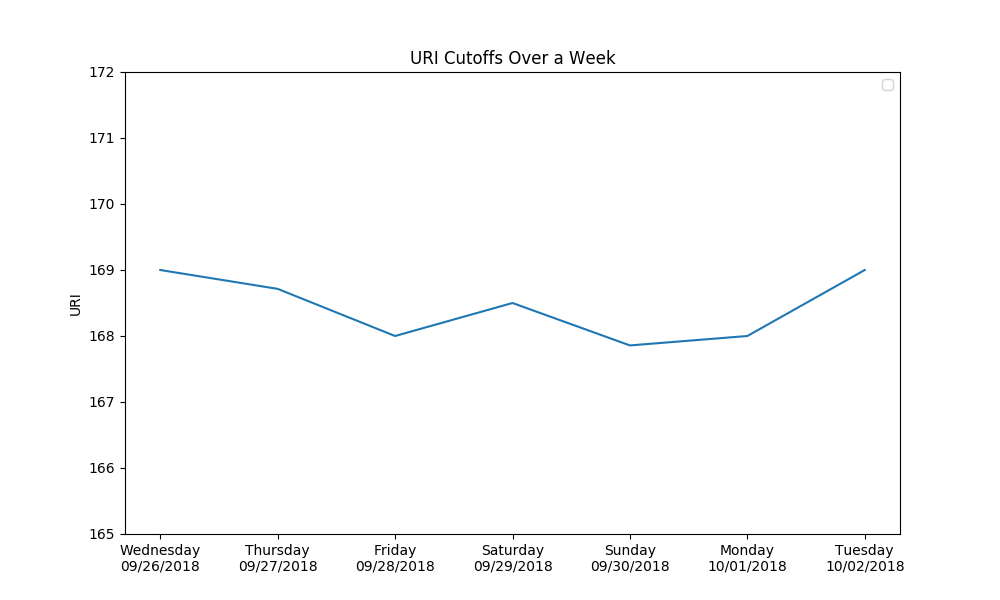

In [17]:
# Graph the URI cutoffs over the consecutive days defined in wk_st_end
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(number_days), uri_cutoff[0:number_days])
ax.set_ylabel('URI')
ax.set_ylim(165, 172)
xticks = array(list(range(0, number_days)))
ax.set_xticks(xticks)
ax.set_xticklabels(daylbl)
ax.set_title(r'URI Cutoffs Over a Week')
ax.legend(loc='best')

display(fig)

In [18]:
# Graph the Search Count cutoffs over the consecutive days defined in wk_st_end
#plt.gcf().clear()
#fig, ax = plt.subplots(figsize=(10,6))
#ax.plot(range(number_days), sc_cutoff[0:number_days])
#ax.set_ylabel('Search Counts')
#ax.set_title(r'Search Count Cutoffs Over a Week')
#xticks = array(list(range(0, number_days)))
#ax.set_xticks(xticks)
#ax.set_xticklabels(daylbl)
#ax.legend(loc='best')
#
#display(fig)

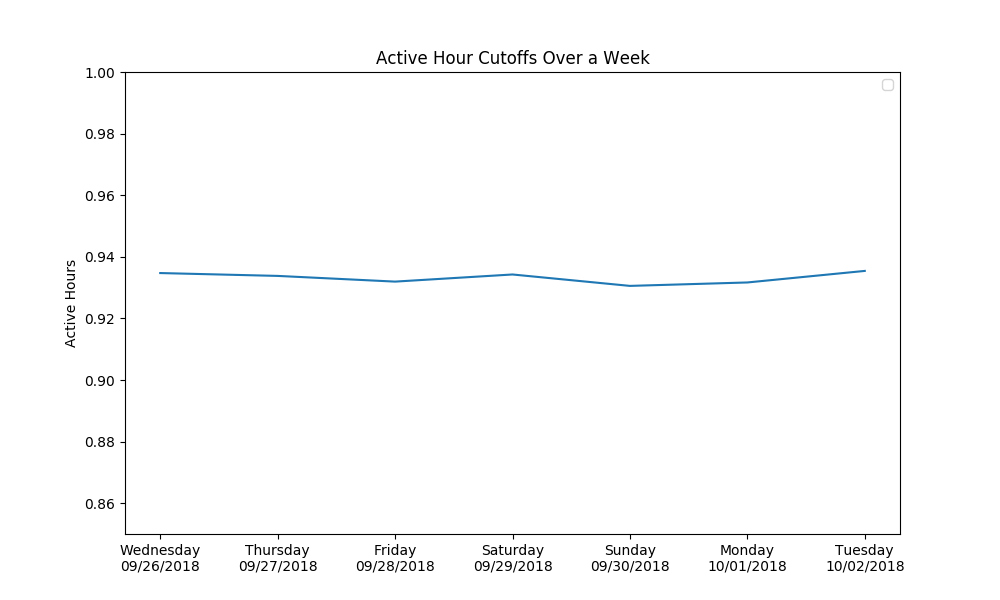

In [19]:
# Graph the Active Hour cutoffs over the consecutive days defined in wk_st_end
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(number_days), ah_cutoff[0:number_days])
ax.set_ylabel('Active Hours')
ax.set_ylim(0.85, 1)
xticks = array(list(range(0, number_days)))
ax.set_xticks(xticks)
ax.set_xticklabels(daylbl)
ax.set_title(r'Active Hour Cutoffs Over a Week')
ax.legend(loc='best')

display(fig)

#### Number of Heavy Users for a week

In [21]:
# This takes longer than average cells
# Get arrays of number of heavy user clients for a day
ms_day = []
day_hu_uri = []
day_hu_sc = []
day_hu_ah = []
uri_num_clients_day = []
sc_num_clients_day = []
ah_num_clients_day = []
# For the list of consecutive days
for i in range(0, number_days):
    print "i " + str(i) + " date: " + wk_st_end[i][1]
    # Get the data from the last day of the week and add it to the list of day data
    ms_day.append(ms_wk[i].where("submission_date_s3 = \'" +  wk_st_end[i][1] + "\'"))

    # Get the data for the heavy users from the day and add it to the list of day heavy users
    day_hu_uri.append(ms_day[i].where('td_uri >= ' + str(uri_cutoff[i])))
    day_hu_sc.append(ms_day[i].where('td_search_counts > '  + str(sc_cutoff[i])))  
    day_hu_ah.append(ms_day[i].where('td_active_hours > '  + str(ah_cutoff[i])))
    
    # Get the number of clients for the heavy users from the day and add it to the list of number of clients
    uri_num_clients_day.append(day_hu_uri[i].select('client_id').distinct().count())
    sc_num_clients_day.append(day_hu_sc[i].select('client_id').distinct().count())
    ah_num_clients_day.append(day_hu_ah[i].select('client_id').distinct().count())

    # Combine the day's heavy user data with the previous days into one big dataframe
    if (i == 1):
        hu_uri = day_hu_uri[i-1].union(day_hu_uri[i])
        hu_sc = day_hu_sc[i-1].union(day_hu_sc[i])
        hu_ah = day_hu_ah[i-1].union(day_hu_ah[i])
    elif (i > 1):
        hu_uri = hu_uri.union(day_hu_uri[i])
        hu_sc = hu_sc.union(day_hu_sc[i])
        hu_ah = hu_ah.union(day_hu_ah[i])

i 0 date: 20180926
i 1 date: 20180927
i 2 date: 20180928
i 3 date: 20180929
i 4 date: 20180930
i 5 date: 20181001
i 6 date: 20181002

In [22]:
uri_num_clients_day

Out[ 15 ]: [207344, 200380, 190513, 134994, 134164, 206185, 208884]

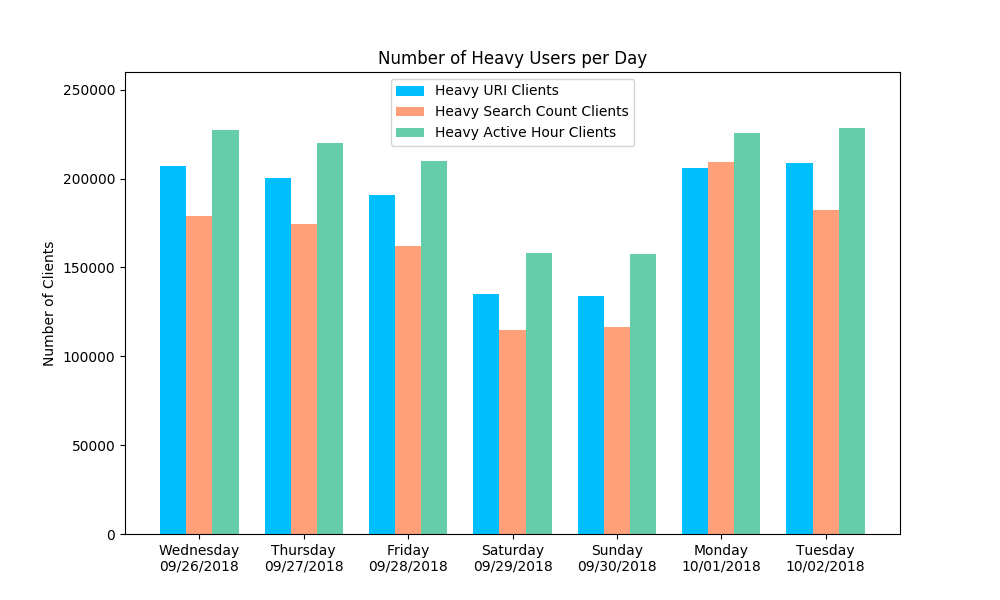

In [23]:
# Generate bar chart for the number of heavy users for a day of the week
width = 0.25
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(10,6))

# the bar chart of the data
xticks = array(list(range(0, number_days)))
ax.bar(xticks - width, uri_num_clients_day[0:number_days], width, label = 'Heavy URI Clients', color = 'deepskyblue')
ax.bar(xticks, sc_num_clients_day[0:number_days], width, label = 'Heavy Search Count Clients', color = 'lightsalmon')
ax.bar(xticks + width, ah_num_clients_day[0:number_days], width, label = 'Heavy Active Hour Clients', color = 'mediumaquamarine')

ax.set_xticks(xticks)
ax.set_xticklabels(daylbl)
ax.set_ylim(0, 260000)
#ax.set_xlabel('Day of the Week')
ax.set_ylabel('Number of Clients')
ax.set_title(r'Number of Heavy Users per Day')
ax.legend(loc='best')

display(fig)

In [24]:
display(hu_uri.select(['submission_date_s3', 'td_uri', 'td_active_hours']).describe())

summary,submission_date_s3,td_uri,td_active_hours
count,1282464,1282464,1282464
mean,2.01809516241914E7,470.35288553908725,1.8507532851691073
stddev,34.5238612153517,2256.881448483945,2.442397728429245
min,20180926,168,0.0
max,20181002,952790,507.725


### Number of days a week for heavy use

In [26]:
# Count all the days for heavy use by uri
huuri_day_count = hu_uri.groupby(['client_id']).count().withColumnRenamed('count','num_days')
# Count the number of clients for a number of days
huuri_freq = huuri_day_count.groupby('num_days') \
      .agg(F.countDistinct('client_id')).withColumnRenamed('count(DISTINCT client_id)', 'uri_num_clients').sort('num_days')

# Count all the days for heavy use by search count
husc_day_count = hu_sc.groupby(['client_id']).count().withColumnRenamed('count','num_days')
# Count the number of clients for a number of days
husc_freq = husc_day_count.groupby('num_days') \
      .agg(F.countDistinct('client_id')).withColumnRenamed('count(DISTINCT client_id)', 'sc_num_clients').sort('num_days')

# Count all the days for heavy use by active hours
huah_day_count = hu_ah.groupby(['client_id']).count().withColumnRenamed('count','num_days')
# Count the number of clients for a number of days
huah_freq = huah_day_count.groupby('num_days') \
      .agg(F.countDistinct('client_id')).withColumnRenamed('count(DISTINCT client_id)', 'ah_num_clients').sort('num_days')

In [27]:
display(huuri_day_count)

client_id,num_days
465c9c63-e1af-42d3-93c9-3f5025e06c07,4
5c5dc10f-4f32-4dd8-bd1e-fdee3c00c7b3,4
754624b7-eec8-d74c-8580-fb97c9564af7,4
7b866e48-942d-40e7-b12e-01ffc99d52e6,3
965a8fe5-8525-b046-bc8d-88fb60412ef9,2
c0bc13ca-2692-4a17-97d9-a254da6b8659,4
dd4bbc91-1a60-4be6-b08e-9328f1079ab1,1
fa20a8de-d295-42a1-8692-322daed09d60,3
180b7759-da7a-43df-a594-5ac3279a38ec,4
3a6e0440-7c25-498e-b9d0-c4f14f04369e,4


In [28]:
display(huuri_freq)

num_days,uri_num_clients
1,208772
2,106411
3,71525
4,53966
5,39673
6,20221
7,15820


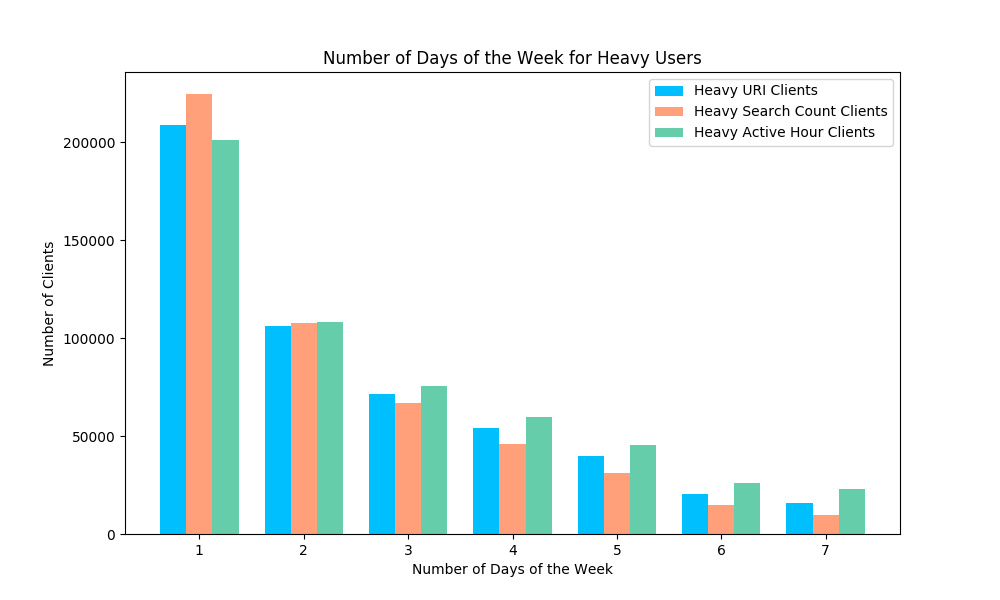

In [29]:
# Generate bar chart
num_day = array(huuri_freq.select('num_days').rdd.flatMap(lambda x:x).collect())
uri_num_clients_arr = array(huuri_freq.select('uri_num_clients').rdd.flatMap(lambda x: x).collect())
sc_num_clients_arr = array(husc_freq.select('sc_num_clients').rdd.flatMap(lambda x: x).collect())
ah_num_clients_arr = array(huah_freq.select('ah_num_clients').rdd.flatMap(lambda x: x).collect())

width = 0.25
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(10,6))

# the bar chart of the data
rects_uri = ax.bar(num_day - width, uri_num_clients_arr, width, label = 'Heavy URI Clients', color = 'deepskyblue')
rects_sc = ax.bar(num_day, sc_num_clients_arr, width, label = 'Heavy Search Count Clients', color = 'lightsalmon')
rects_ah = ax.bar(num_day + width, ah_num_clients_arr, width, label = 'Heavy Active Hour Clients', color = 'mediumaquamarine')

ax.set_xlabel('Number of Days of the Week')
ax.set_ylabel('Number of Clients')
ax.set_title(r'Number of Days of the Week for Heavy Users')
ax.legend(loc='best')

display(fig)

If there are similar amounts of heavy users each day of the week, how come the heavy user counts fall off so much for more than 1 day a week?

There are different heavy users each day of the week.

In [31]:
# Wednesday's URI heavy users
display(day_hu_uri[0].select(['submission_date_s3', 'td_uri', 'td_active_hours']).describe())

summary,submission_date_s3,td_uri,td_active_hours
count,207344,207344,207344
mean,2.0180926E7,468.8934668955938,1.8151558856028853
stddev,0.0,2021.1507655243204,2.526737216208413
min,20180926,169,0.0
max,20180926,502183,441.70138888888886


In [32]:
# Thursday's URI heavy users
display(day_hu_uri[1].select(['submission_date_s3', 'td_uri', 'td_active_hours']).describe())

summary,submission_date_s3,td_uri,td_active_hours
count,200380,200380,200380
mean,2.0180927E7,467.6435821938317,1.8112928283483611
stddev,0.0,1838.2600552293745,2.5460008856269623
min,20180927,169,0.0
max,20180927,548160,395.9972222222223


In [33]:
# URI Heavy Users on Wednesday but not Thursday
only_w = day_hu_uri[0].join(day_hu_uri[1], 'client_id', 'left_anti')
display(only_w.select(['submission_date_s3', 'td_uri', 'td_active_hours']).describe())

summary,submission_date_s3,td_uri,td_active_hours
count,100924,100924,100924
mean,2.0180926E7,376.08980024572946,1.5259449217012593
stddev,0.0,1617.0547626467617,1.729703797554007
min,20180926,169,0.0
max,20180926,341541,342.95416666666694


In [34]:
# URI Heavy Users on Thursday but not Wednesday
only_th = day_hu_uri[1].join(day_hu_uri[0], 'client_id', 'left_anti')
display(only_th.select(['submission_date_s3', 'td_uri', 'td_active_hours']).describe())

summary,submission_date_s3,td_uri,td_active_hours
count,93960,93960,93960
mean,2.0180927E7,377.284269902086,1.559567073459155
stddev,0.0,1061.7920972718512,1.9307255627597657
min,20180927,169,0.0
max,20180927,205973,326.6819444444444


In [35]:
# URI Heavy Users on Wednesday who are also on Thursday
both = day_hu_uri[0].join(day_hu_uri[1], 'client_id')

In [36]:
only_w_cnt = only_w.count()
only_th_cnt = only_th.count()
both_cnt = both.count()
print 'Heavy Users on Wednesday but not Thursday ' + str(only_w_cnt)
print 'Heavy Users on Thursday but not Wednesday ' + str(only_th_cnt)
print 'Heavy Users both days ' + str(both_cnt)

Heavy Users on Wednesday but not Thursday 100924
Heavy Users on Thursday but not Wednesday 93960
Heavy Users both days 106420

In [37]:
# Get all the URI heavy users in the week with 1 day of heavy use
huuri_1day = huuri_day_count.where('num_days == 1')
uri_1day = hu_uri.join(huuri_1day, 'client_id')
display(uri_1day.select(['submission_date_s3', 'td_uri', 'td_active_hours', 'num_days']))

submission_date_s3,td_uri,td_active_hours,num_days
20180929,196,0.8125,1
20181002,181,0.34305555555555556,1
20180928,491,0.0,1
20181002,269,2.531944444444445,1
20180930,284,1.4236111111111112,1
20181002,237,1.2291666666666665,1
20180929,425,3.609722222222222,1
20180926,1227,3.9416666666666664,1
20180926,180,2.5708333333333333,1
20181001,196,1.3375,1


In [38]:
husc_1day = husc_day_count.where('num_days == 1')
sc_1day = hu_sc.join(husc_1day, 'client_id')

huah_1day = huah_day_count.where('num_days == 1')
ah_1day = hu_ah.join(huah_1day, 'client_id')

# Count the number of heavy users each day for clients with only 1 day of heavy use
uri_1day_count = uri_1day.groupby(['submission_date_s3']).count().withColumnRenamed('count','num_clients').sort('submission_date_s3')
sc_1day_count = sc_1day.groupby(['submission_date_s3']).count().withColumnRenamed('count','num_clients').sort('submission_date_s3')
ah_1day_count = ah_1day.groupby(['submission_date_s3']).count().withColumnRenamed('count','num_clients').sort('submission_date_s3')

In [39]:
uri_1day_clients_arr = array(uri_1day_count.select('num_clients').rdd.flatMap(lambda x: x).collect())
sc_1day_clients_arr = array(sc_1day_count.select('num_clients').rdd.flatMap(lambda x: x).collect())
ah_1day_clients_arr = array(ah_1day_count.select('num_clients').rdd.flatMap(lambda x: x).collect())

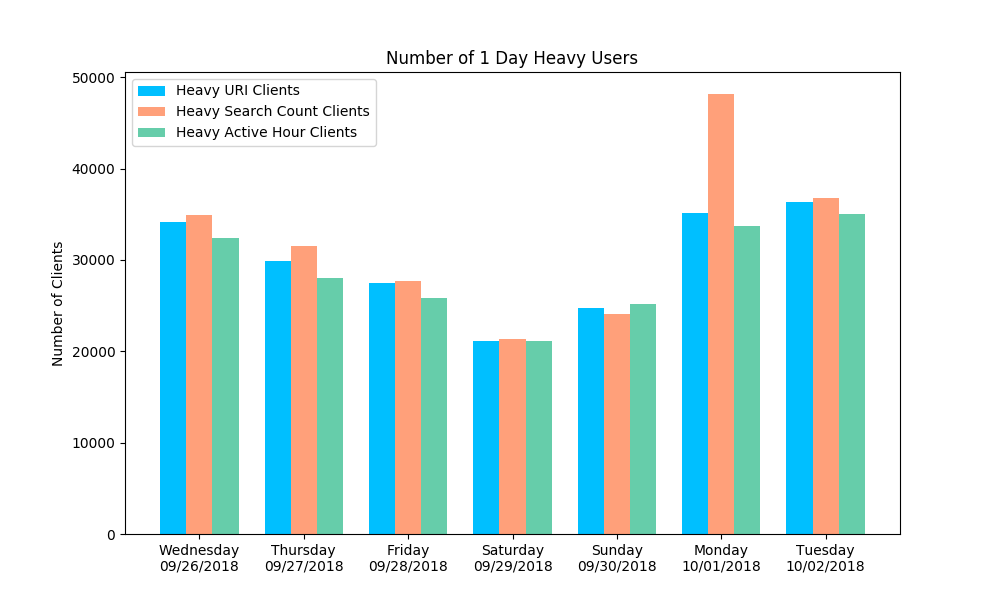

In [40]:
# Generate bar chart
width = 0.25
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(10,6))

# the bar chart of the data
xticks = array(list(range(0, number_days)))
#ax.bar(xticks, uri_1day_clients_arr, width, label = 'Heavy URI Clients', color = 'deepskyblue')
ax.bar(xticks - width, uri_1day_clients_arr[0:number_days], width, label = 'Heavy URI Clients', color = 'deepskyblue')
ax.bar(xticks, sc_1day_clients_arr[0:number_days], width, label = 'Heavy Search Count Clients', color = 'lightsalmon')
ax.bar(xticks + width, ah_1day_clients_arr[0:number_days], width, label = 'Heavy Active Hour Clients', color = 'mediumaquamarine')

ax.set_xticks(xticks)
ax.set_xticklabels(daylbl)
#ax.set_xlabel('Day of the Week')
ax.set_ylabel('Number of Clients')
ax.set_title(r'Number of 1 Day Heavy Users')
ax.legend(loc='best')

display(fig)

#### Retention

In [42]:
PERIODS = {}
N_WEEKS = 6
for i in range(1, N_WEEKS + 1):
    PERIODS[i] = {
        'start': i * 7,
        'end': i * 7 + 6
    }  

In [43]:
import datetime as dt
import pandas as pd
import pyspark.sql.types as st
import pyspark.sql.functions as F

udf = F.udf

def date_diff(d1, d2, fmt='%Y%m%d'):
    """
    Returns days elapsed from d2 to d1 as an integer

    Params:
    d1 (str)
    d2 (str)
    fmt (str): format of d1 and d2 (must be the same)

    >>> date_diff('20170205', '20170201')
    4

    >>> date_diff('20170201', '20170205)
    -4
    """
    try:
        return (pd.to_datetime(d1, format=fmt) -
                pd.to_datetime(d2, format=fmt)).days
    except:
        return None


@udf(returnType=st.IntegerType())
def get_period(anchor, submission_date_s3):
    """
    Given an anchor and a submission_date_s3,
    returns what period a ping belongs to. This
    is a spark UDF.

    Params:
    anchor (col): anchor date
    submission_date_s3 (col): a ping's submission_date to s3

    Global:
    PERIODS (dict): defined globally based on n-week method

    Returns an integer indicating the retention period
    """
    if anchor is not None:
        diff = date_diff(submission_date_s3, anchor)
        if diff >= 7: # exclude first 7 days
            for period in sorted(PERIODS):
                if diff <= PERIODS[period]['end']:
                    return period


In [44]:
# Start of the baseline week
base_start = wk_st_end[0][0]
base_end = wk_st_end[0][1]
# Last date for the number of weeks
num_week_days = num_weeks * 7
weekx_end = wk_st_end[num_week_days-1][1]

In [45]:
co_dates = []
for i in range(0, len(wk_st_end)):
    co_dates.append(wk_st_end[i][1])
co_dates

Out[ 35 ]: 
['20180926',
 '20180927',
 '20180928',
 '20180929',
 '20180930',
 '20181001',
 '20181002',
 '20181003',
 '20181004',
 '20181005',
 '20181006',
 '20181007',
 '20181008',
 '20181009',
 '20181010',
 '20181011',
 '20181012',
 '20181013',
 '20181014',
 '20181015',
 '20181016',
 '20181017',
 '20181018',
 '20181019',
 '20181020',
 '20181021',
 '20181022',
 '20181023',
 '20181024',
 '20181025',
 '20181026',
 '20181027',
 '20181028',
 '20181029',
 '20181030',
 '20181031',
 '20181101',
 '20181102',
 '20181103',
 '20181104',
 '20181105',
 '20181106',
 '20181107']

In [46]:
ms_xweek = spark.sql("""
    SELECT 
      client_id,
      submission_date_s3,
      sum(coalesce(scalar_parent_browser_engagement_total_uri_count, 0)) AS td_uri, 
      sum(coalesce(scalar_parent_browser_engagement_active_ticks, 0)*5/3600) AS td_active_hours,
      first(sample_id) AS sample_id
    FROM main_summary
    WHERE 
      app_name='Firefox'
      AND submission_date_s3 >= '{}'
      AND submission_date_s3 <= '{}'
      AND sample_id = '{}'
    GROUP BY
        1, 2
    """.format(base_start, weekx_end, sample_id)
    )

search_xweek = spark.sql("""
  SELECT client_id,
       submission_date_s3,
       engine,
       SUM(sap) as sap,
       SUM(tagged_sap) as tagged_sap,
       SUM(tagged_follow_on) as tagged_follow_on,
       SUM(organic) as in_content_organic
  FROM search_clients_daily
  WHERE
      submission_date_s3 >= '{}'
      AND submission_date_s3 <= '{}'
      AND sample_id = '{}'
  GROUP BY
      1, 2, 3
    """.format(base_start, weekx_end, sample_id)
    )

In [47]:
search_xweek = search_xweek.na.fill(0)
sc_xweek = search_xweek.groupBy('client_id', 'submission_date_s3') \
                     .agg(F.sum(F.col('sap') + F.col('in_content_organic'))) \
                     .withColumnRenamed('sum((sap + in_content_organic))','td_search_counts') \
                     .sort('client_id', 'submission_date_s3')
# Join the main summary and search data for the week
ms_ret = ms_xweek.join(sc_xweek, ['client_id', 'submission_date_s3'], 'full_outer').na.fill(0)

In [48]:
display(ms_ret.select(['submission_date_s3', 'td_uri', 'td_active_hours', 'sample_id']).describe())

summary,submission_date_s3,td_uri,td_active_hours,sample_id
count,43652596,43652596,43652596,43652596
mean,2.01810058518788E7,125.47378604928788,0.6486501347543805,42.0
stddev,52.32270802096658,1326.3992021516658,3.7764224199592165,0.0
min,20180920,0,-23300.040277777774,42
max,20181106,4530092,654.4569444444438,42


In [49]:
def calc_retention(heavy_col_name, heavy_co_arr, heavy_co_date, anchor_start, anchor_end):
    """
    Given a dataframe, heavy column name, heavy cutoff, and base week end date,
    returns dataframe with retention for heavy user type for each period.
    
    Params:
    heavy_col_name (string): name of the column for heavy user
    heavy_co_arr (array numbers): an array of cutoff values to define a heavy user for a date
    heavy_co_date (array dates): an array of dates for the cutoff values
    anchor_start (date): date for the start of the anchor week
    anchor_end (date): date for the end of the anchor week
    
    Returns dataframe with retention for heavy user type for each period
    """
  
    # Get heavy users
    for i in range(0, len(heavy_co_date)):
        if i == 0:
            hu_where = "(submission_date_s3 <= " + heavy_co_date[i] + " and " + heavy_col_name + " >= " + str(heavy_co_arr[i]) + ")"
        else:
            hu_where = hu_where + " or (submission_date_s3 = " + heavy_co_date[i] + " and " + heavy_col_name + " >= " + str(heavy_co_arr[i]) + ")"
    print hu_where
            
    ms_ret_hu = ms_ret.where(hu_where)
    # Get base week of heavy users
    base_hu = ms_ret_hu \
        .where("submission_date_s3 >= \'" +  anchor_start + "\' and submission_date_s3 <= \'" +  anchor_end + "\'") \
        .select('client_id').distinct()
    # Count unique clients in base week of heavy users
    base_num_clients = base_hu.select('client_id').distinct().count()
    # Get only base week heavy users for the entire time
    ret_hu = ms_ret_hu.join(base_hu, on='client_id')
    # Add period column
    ret_hu = ret_hu.withColumn("anchor", F.lit(base_start)) \
                   .withColumn("period", get_period("anchor", "submission_date_s3"))
    # Group by period and count the number of distinct clients
    hu_weekly_counts = ret_hu.groupby("period").agg(F.countDistinct("client_id").alias("n_week_clients"))
    # Add column with calculated retention and 95% CI
    hu_retention = (
        hu_weekly_counts
            .withColumn("total_clients", F.lit(base_num_clients))
            .withColumn("retention", F.col("n_week_clients") / F.col("total_clients"))
            # Add a 95% confidence interval based on the normal approximation for a binomial distribution,
            # p ± z * sqrt(p*(1-p)/n).
            # The 95% CI spans the range `retention ± ci_95_semi_interval`.
            .withColumn(
                "ci_95_semi_interval",
                F.lit(1.96) * F.sqrt(F.col("retention") * (F.lit(1) - F.col("retention")) / F.col("total_clients"))
            )
    )
    return hu_retention

In [50]:
huuri_retention = calc_retention('td_uri', uri_cutoff, co_dates, base_start, base_end)
huuri_ret = huuri_retention['period', 'retention', 'ci_95_semi_interval'].where("retention < 1").sort('period')
display(huuri_ret)

period,retention,ci_95_semi_interval
1,0.7040890286249493,0.0012471153981526194
2,0.6684103447002746,0.001286276653707871
3,0.6485588423325127,0.0013044076044485529
4,0.6358737789557752,0.0013146911955981748
5,0.6203691648805626,0.0013259225629520016
6,0.5739680269557597,0.0013510681814786665


In [51]:
huah_retention = calc_retention('td_active_hours', ah_cutoff, co_dates, base_start, base_end)
huah_ret = huah_retention['period', 'retention', 'ci_95_semi_interval'].where("retention < 1").sort('period')
display(huah_ret)

period,retention,ci_95_semi_interval
1,0.727999642050825,0.0011908757741243775
2,0.6919493129053728,0.0012355615134363534
3,0.6716301042713404,0.0012567904862030167
4,0.6587625771594868,0.001268846033789329
5,0.641541866071079,0.001283358115264819
6,0.5969212642317423,0.0013127124639485386


In [52]:
husc_retention = calc_retention('td_search_counts', sc_cutoff, co_dates, base_start, base_end)
husc_ret = husc_retention['period', 'retention', 'ci_95_semi_interval'].where("retention < 1").sort('period')
display(husc_ret)

period,retention,ci_95_semi_interval
1,0.6800664962098968,0.0012289555046508228
2,0.6501594644163964,0.0012565379720420684
3,0.6287108228002494,0.0012729525678659643
4,0.6178762772964231,0.0012802163484854543
5,0.6032362693457893,0.0012889625919445236
6,0.5576249288508623,0.0013085701863733224


In [53]:
weeks = array(huuri_ret.select('period').rdd.flatMap(lambda x:x).collect())
uri_ret = array(huuri_ret.select('retention').rdd.flatMap(lambda x: x).collect())
sc_ret = array(husc_ret.select('retention').rdd.flatMap(lambda x: x).collect())
ah_ret = array(huah_ret.select('retention').rdd.flatMap(lambda x: x).collect())


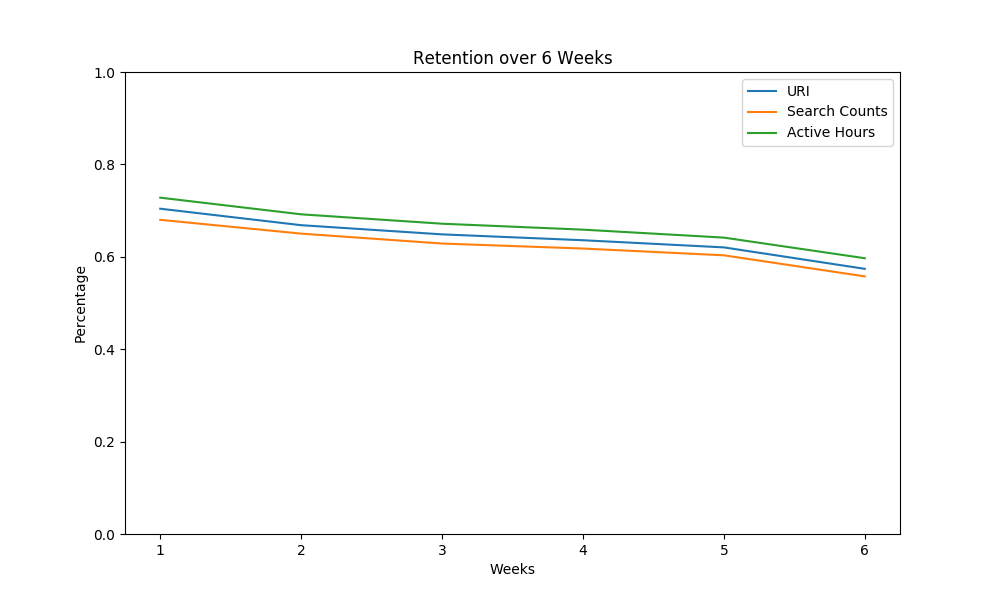

In [54]:
# Graph retention over multiple weeks
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(weeks, uri_ret, label='URI')
ax.plot(weeks, sc_ret, label='Search Counts')
ax.plot(weeks, ah_ret, label='Active Hours')
ax.set_ylabel('Percentage')
ax.set_ylim(0, 1)
ax.set_xlabel('Weeks')
ax.set_title('Retention over ' + str(num_weeks) + ' Weeks')
ax.legend(loc='best')

display(fig)

#### Attributes of Heavy Users

The attributes of Heavy Users can be seen in this notebook: <a href="https://dbc-caf9527b-e073.cloud.databricks.com/#notebook/73994/command/76992">Heavy User Attributes</a>